In [1]:
import pandas as pd
import numpy as np

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

import matplotlib.cm as cm
import matplotlib.colors as colors

print("Necessary libraries imported!")

Solving environment: done

# All requested packages already installed.

Necessary libraries imported!


In [2]:
#importing data on the neighborhoods in DC. file from open source data provided by dc government


import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_a99f09866cc1481aae96125ff4652dcf = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='LX7LoWeqFT0a0UaZI0Civv3TzWXtieg7VStzqnRAXJdK',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_a99f09866cc1481aae96125ff4652dcf.get_object(Bucket='courseracapstone-donotdelete-pr-lqwzqjhtbu3rws',Key='Neighborhood_Labels.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,X,Y,OBJECTID,GIS_ID,NAME,WEB_URL,LABEL_NAME,DATELASTMODIFIED
0,-76.980348,38.855658,1,nhood_050,Fort Stanton,http://NeighborhoodAction.dc.gov,Fort Stanton,2003/04/10 00:00:00+00
1,-76.997950,38.841077,2,nhood_031,Congress Heights,http://NeighborhoodAction.dc.gov,Congress Heights,2003/04/10 00:00:00+00
2,-76.995636,38.830237,3,nhood_123,Washington Highlands,http://NeighborhoodAction.dc.gov,Washington Highlands,2003/04/10 00:00:00+00
3,-77.009271,38.826952,4,nhood_008,Bellevue,http://NeighborhoodAction.dc.gov,Bellevue,2003/04/10 00:00:00+00
4,-76.967660,38.853688,5,nhood_073,Knox Hill/Buena Vista,http://NeighborhoodAction.dc.gov,Knox Hill/Buena Vista,2003/04/10 00:00:00+00


In [3]:
#selecting desired columns for data frame
dc_data=df_data_1[['NAME','Y','X']]
dc_data.head()

,NAME,Y,X
0,Fort Stanton,38.855658,-76.980348
1,Congress Heights,38.841077,-76.997950
2,Washington Highlands,38.830237,-76.995636
3,Bellevue,38.826952,-77.009271
4,Knox Hill/Buena Vista,38.853688,-76.967660


In [4]:
#renaming columns
dc_data.columns=['Neighborhood','Latitude','Longitude']
dc_data.head()

,Neighborhood,Latitude,Longitude
0,Fort Stanton,38.855658,-76.980348
1,Congress Heights,38.841077,-76.997950
2,Washington Highlands,38.830237,-76.995636
3,Bellevue,38.826952,-77.009271
4,Knox Hill/Buena Vista,38.853688,-76.967660


In [6]:
#foursquare credentials
CLIENT_ID = 'DVZZ3MQQTQYKWTIGQSDRYLWFSCWS1MY3AXVLCUMDKDG25GLM' 
CLIENT_SECRET = 'Z3BLL2BPRTWIZXSFYKFDJ2CUDEXR0PPZYQCUYAU24F4NK3DG'
VERSION = '20180605' 
LIMIT = 100 

print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: DVZZ3MQQTQYKWTIGQSDRYLWFSCWS1MY3AXVLCUMDKDG25GLM
CLIENT_SECRET:Z3BLL2BPRTWIZXSFYKFDJ2CUDEXR0PPZYQCUYAU24F4NK3DG


In [7]:
#importing necessary libraries

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [8]:
#function that pulls information from foursquare on museums

def getMuseums(names, latitudes, longitudes, radius=500, categories='4bf58dd8d48988d181941735'):
    
    museums_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categories)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        museums_list.append([(
            name, 
            lat, 
            lng, 
            m['name'], 
            m['id'],
            m['location']['lat'], 
            m['location']['lng'],  
            m['categories'][0]['name']) for m in results])

    nearby_museums = pd.DataFrame([item for museums_list in museums_list for item in museums_list])
    nearby_museums.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Museum',
                  'Museum ID',
                  'Museum Latitude', 
                  'Museum Longitude', 
                  'Museum Category']
    
    return(nearby_museums)

In [9]:
#running the getMuseums function using the dc_data
dc_museums=getMuseums(names=dc_data['Neighborhood'],latitudes=dc_data['Latitude'],longitudes=dc_data['Longitude'])

In [10]:
#obtaining desired museum categories
indexes_for_drop=[]

for index,rows in dc_museums.iterrows():
    category = dc_museums['Museum Category'].values[index]
    if ((category != 'Art Museum')and(category != 'History Museum')and(category != 'Museum')and(category != 'Science Museum')):
        indexes_for_drop.append(index)
        
dc_museums_filtered=dc_museums.drop(indexes_for_drop, axis=0)

In [11]:
#reseting index of data frame
dc_museums_filtered.reset_index(drop=True, inplace=True)

In [12]:
#renaming museum categories
dc_museums_filtered.replace(to_replace={'Museum Category':{'Museum':'Other','History Museum':'History','Art Museum':'Art','Science Museum':'Science'}}, inplace=True)

In [15]:
#quick look at the data frame
dc_museums_filtered

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Museum,Museum ID,Museum Latitude,Museum Longitude,Museum Category
0,Fort Stanton,38.855658,-76.980348,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,38.856728,-76.976899,Other
1,Woodland,38.856554,-76.973926,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,38.856728,-76.976899,Other
2,Garfield Heights,38.854085,-76.972213,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,38.856728,-76.976899,Other
3,Historic Anacostia,38.863186,-76.984678,Frederick Douglass National Historic Site (NHS),4b1163ebf964a5207e7b23e3,38.863735,-76.984418,History
4,Columbia Heights,38.928008,-77.030586,Icelandic,4f4da350e4b0393387215383,38.925041,-77.028465,Art
...,...,...,...,...,...,...,...,...
194,Mount Vernon Square,38.904340,-77.023313,"The Historical Society of Washington, D.C.",4b534c10f964a520109627e3,38.902522,-77.022963,History
195,Mount Vernon Square,38.904340,-77.023313,Touchstone Gallery,4c127737b7b9c92838d6a737,38.902127,-77.025283,Art
196,Mount Vernon Square,38.904340,-77.023313,German-American Heritage Museum,4ba64954f964a520944239e3,38.899389,-77.019585,History
197,Mount Vernon Square,38.904340,-77.023313,Flight 93 Memorial Plaque,52309c7f11d2899699b367cc,38.900311,-77.023605,History


In [16]:
#function that pulls the foursquare rating of each museum

def getMuseumRating(museum_ID):
    
    museum_ratings_list=[]
    for each in museum_ID:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            each,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
        results = requests.get(url).json()['response']['venue']
        
        # return only museums that contain a rating
        try:
            museum_name = results['name']
            museum_id = results['id']
            museum_rating = results['rating']
            museum_ratings_list.append([museum_name, museum_id, museum_rating])
        except: 
            pass
        
    column_names=['Museum Name','Museum ID','Museum Rating']
    museum_ratings = pd.DataFrame(museum_ratings_list, columns=column_names)
    
    return(museum_ratings)

In [17]:
#running getMuseumRating function on list of dc museums to obtain the ratings of each museum
dc_rated_museums=getMuseumRating(museum_ID=dc_museums_filtered['Museum ID'].values.tolist())

In [18]:
#dropping duplicated museums
dc_rated_museums.drop_duplicates(inplace=True)
dc_rated_museums.head()

,Museum Name,Museum ID,Museum Rating
0,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,7.9
3,Frederick Douglass National Historic Site (NHS),4b1163ebf964a5207e7b23e3,8.2
4,African American Civil War Museum,4bed9ac6e3562d7f8645fff8,7.5
5,"Hillwood Estate, Museum & Gardens",4b0dbc98f964a520f34e23e3,8.7
6,Smithsonian American Art Museum,4a299b7df964a520b2951fe3,9.2


In [19]:
#merging the data frame containing neighborhoods and museums with the dataframe containing museum ratings
dc_rated_museums=pd.merge(left=dc_museums_filtered, right=dc_rated_museums, left_on='Museum ID', right_on='Museum ID')
dc_rated_museums.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Museum,Museum ID,Museum Latitude,Museum Longitude,Museum Category,Museum Name,Museum Rating
0,Fort Stanton,38.855658,-76.980348,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,38.856728,-76.976899,Other,Anacostia Community Museum,7.9
1,Woodland,38.856554,-76.973926,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,38.856728,-76.976899,Other,Anacostia Community Museum,7.9
2,Garfield Heights,38.854085,-76.972213,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,38.856728,-76.976899,Other,Anacostia Community Museum,7.9
3,Historic Anacostia,38.863186,-76.984678,Frederick Douglass National Historic Site (NHS),4b1163ebf964a5207e7b23e3,38.863735,-76.984418,History,Frederick Douglass National Historic Site (NHS),8.2
4,Cardozo/Shaw,38.917168,-77.027550,African American Civil War Museum,4bed9ac6e3562d7f8645fff8,38.916478,-77.027635,History,African American Civil War Museum,7.5


In [20]:
#dropping museum name column as it is a duplicate
dc_rated_museums.drop(columns=['Museum Name'], inplace=True)
dc_rated_museums.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Museum,Museum ID,Museum Latitude,Museum Longitude,Museum Category,Museum Rating
0,Fort Stanton,38.855658,-76.980348,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,38.856728,-76.976899,Other,7.9
1,Woodland,38.856554,-76.973926,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,38.856728,-76.976899,Other,7.9
2,Garfield Heights,38.854085,-76.972213,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,38.856728,-76.976899,Other,7.9
3,Historic Anacostia,38.863186,-76.984678,Frederick Douglass National Historic Site (NHS),4b1163ebf964a5207e7b23e3,38.863735,-76.984418,History,8.2
4,Cardozo/Shaw,38.917168,-77.027550,African American Civil War Museum,4bed9ac6e3562d7f8645fff8,38.916478,-77.027635,History,7.5


In [21]:
#Displaying top 5 museums and their ratings
top_5_museums = dc_rated_museums[['Museum','Museum Category','Museum Rating']]
top_5_museums.drop_duplicates(inplace=True)
top_5_museums.sort_values(by=['Museum Rating'], ascending=False , inplace=True)
top_5_museums.reset_index(drop=True, inplace=True)
top_5_museums.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Museum,Museum Category,Museum Rating
0,National Gallery of Art,Art,9.4
1,National Portrait Gallery,Art,9.3
2,National Gallery of Art - West Building,Art,9.3
3,National Air and Space Museum,Science,9.2
4,Smithsonian American Art Museum,Art,9.2


In [22]:
#creating new data frames that are museum category specific
all_museums = dc_rated_museums[['Museum','Museum Category','Museum Rating']]
art_museums = all_museums[all_museums['Museum Category'] == 'Art']
science_museums = all_museums[all_museums['Museum Category'] == 'Science']
history_museums = all_museums[all_museums['Museum Category'] == 'History']
other_museums = all_museums[all_museums['Museum Category'] == 'Other']

In [23]:
#displaying top 5 art museums and their ratings
art_museums.drop_duplicates(inplace=True)
art_museums.sort_values(by=['Museum Rating'], ascending=False , inplace=True)
art_museums.reset_index(drop=True, inplace=True)
art_museums.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Museum,Museum Category,Museum Rating
0,National Gallery of Art,Art,9.4
1,National Portrait Gallery,Art,9.3
2,National Gallery of Art - West Building,Art,9.3
3,Smithsonian American Art Museum,Art,9.2
4,Renwick Gallery,Art,9.1


In [24]:
#displaying top 5 science museums and their ratings
science_museums.drop_duplicates(inplace=True)
science_museums.sort_values(by=['Museum Rating'], ascending=False , inplace=True)
science_museums.reset_index(drop=True, inplace=True)
science_museums.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Museum,Museum Category,Museum Rating
0,National Air and Space Museum,Science,9.2
1,Smithsonian National Museum of Natural History...,Science,9.1
2,Phoebe Waterman Haas Public Observatory,Science,8.9
3,Flight Simulator,Science,7.4
4,Sant Ocean Hall,Science,7.3


In [25]:
#displaying top 5 history museums and their ratings
history_museums.drop_duplicates(inplace=True)
history_museums.sort_values(by=['Museum Rating'], ascending=False , inplace=True)
history_museums.reset_index(drop=True, inplace=True)
history_museums.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Museum,Museum Category,Museum Rating
0,National Archives Rotunda,History,8.5
1,United States Holocaust Memorial Museum,History,8.4
2,Heurich Mansion (The Brewmaster's Castle),History,8.4
3,National Postal Museum,History,8.4
4,Ford's Theater Center for Education & Leadership,History,8.3


In [26]:
#displaying top 5 other museums and their ratings
other_museums.drop_duplicates(inplace=True)
other_museums.sort_values(by=['Museum Rating'], ascending=False , inplace=True)
other_museums.reset_index(drop=True, inplace=True)
other_museums.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Museum,Museum Category,Museum Rating
0,National Archives and Records Administration,Other,8.8
1,The Kreeger Museum,Other,8.8
2,International Spy Museum,Other,8.7
3,National Building Museum,Other,8.3
4,National Geographic Society,Other,8.2


In [31]:
#making dataframe of the top museum from each category
top_of_each_category=pd.concat([art_museums.head(1),science_museums.head(1),history_museums.head(1),other_museums.head(1)])
top_of_each_category.sort_values(by=['Museum Rating'], ascending=False , inplace=True)
top_of_each_category.reset_index(drop=True, inplace=True)
top_of_each_category.head()

,Museum,Museum Category,Museum Rating
0,National Gallery of Art,Art,9.4
1,National Air and Space Museum,Science,9.2
2,National Archives and Records Administration,Other,8.8
3,National Archives Rotunda,History,8.5


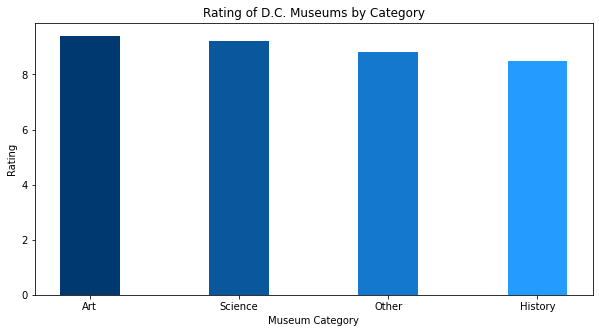

In [38]:
# creating the bar chart to show rankings of museum categories

import matplotlib.pyplot as plt  
  
fig = plt.figure(figsize = (10, 5)) 
x_values=top_of_each_category['Museum Category']
y_values=top_of_each_category['Museum Rating']

plt.bar(x_values, y_values, color = ["#003870","#0A579E","#1578CF","#249CFF"], width = 0.4) 
  
plt.xlabel("Museum Category") 
plt.ylabel("Rating") 
plt.title("Rating of D.C. Museums by Category") 
plt.show() 

In [40]:
#creating a map of DC showing each museum and their rating and category
dc_lat = 38.9072
dc_long = -77.0369

map_dc_museums = folium.Map(location=[dc_lat, dc_long], zoom_start=12)

color_outline_array=[]
color_fill_array=[]
i=0

#color coding markers based on museum category
for category in dc_rated_museums['Museum Category']:
    if (category=='Other'):
        color_outline_array.append('blue') 
        color_fill_array.append('#3186cc')
    if (category=='Art'):
        color_outline_array.append('red')
        color_fill_array.append('#e64940')
    if (category=='Science'):
        color_outline_array.append('green')
        color_fill_array.append('#7ead7d')
    if (category=='History'):
        color_outline_array.append('purple')
        color_fill_array.append('#a578b3')
    
    i=i+1
    
i = 0
for lat, lng, name, rating, category in zip(dc_rated_museums['Museum Latitude'], dc_rated_museums['Museum Longitude'], dc_rated_museums['Museum'], dc_rated_museums['Museum Rating'],dc_rated_museums['Museum Category']):
    label = folium.Popup('Name: ' + name + '; Category: ' + category + '; Rating: ' + str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7,
        fill_color=color_fill_array[i],
        color=color_fill_array[i]
    ).add_to(map_dc_museums)  
    i=i+1
    
map_dc_museums

In [41]:
#one hot encoding
dc_onehot = pd.get_dummies(dc_rated_museums[['Museum Category']], prefix="", prefix_sep="")

#add neighborhood column back to dataframe as the first column
dc_onehot.insert(0,'Neighborhood', dc_rated_museums['Neighborhood'])

dc_onehot

,Neighborhood,Art,History,Other,Science
0,Fort Stanton,0,0,1,0
1,Woodland,0,0,1,0
2,Garfield Heights,0,0,1,0
3,Historic Anacostia,0,1,0,0
4,Cardozo/Shaw,0,1,0,0
...,...,...,...,...,...
74,Dupont Circle,0,0,1,0
75,Dupont Circle,0,1,0,0
76,Dupont Circle,0,1,0,0
77,Lanier Heights,1,0,0,0


In [42]:
#group rows by neighborhood and by taking the mean of the frequency of occurence of each category

dc_grouped = dc_onehot.groupby('Neighborhood').mean().reset_index()
dc_grouped.head()

,Neighborhood,Art,History,Other,Science
0,Cardozo/Shaw,0.0,1.000000,0.000000,0.0
1,Chinatown,0.5,0.200000,0.300000,0.0
2,Connecticut Avenue/K Street,0.2,0.400000,0.400000,0.0
3,Downtown,0.5,0.166667,0.333333,0.0
4,Downtown East,0.0,0.500000,0.500000,0.0


In [43]:
#function to sort venues in descending order

def return_most_common_museums(row, num_top_venues):
    row_categories=row.iloc[1:]
    
    row_categories_sorted=row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
#dataframe displaying top 4 museum categories for each neighborhood

num_top_venues = 4

indicators = ['st','nd','rd', 'th']

columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    columns.append('{}{} Most Common Museum Category'.format(ind+1,indicators[ind]))

neighborhood_museums_sorted=pd.DataFrame(columns=columns)
neighborhood_museums_sorted['Neighborhood']=dc_grouped['Neighborhood']

for ind in np.arange(dc_grouped.shape[0]):
    neighborhood_museums_sorted.iloc[ind,1:]=return_most_common_museums(dc_grouped.iloc[ind,:], num_top_venues)

neighborhood_museums_sorted.head()

,Neighborhood,1st Most Common Museum Category,2nd Most Common Museum Category,3rd Most Common Museum Category,4th Most Common Museum Category
0,Cardozo/Shaw,History,Art,Other,Science
1,Chinatown,Art,Other,History,Science
2,Connecticut Avenue/K Street,History,Other,Art,Science
3,Downtown,Art,Other,History,Science
4,Downtown East,History,Other,Art,Science


In [45]:
#adding location to the data table with the top categories for each neighborhood
dc_final_table=pd.merge(left=dc_data, right=neighborhood_museums_sorted, left_on='Neighborhood', right_on='Neighborhood')
dc_final_table.head()

,Neighborhood,Latitude,Longitude,1st Most Common Museum Category,2nd Most Common Museum Category,3rd Most Common Museum Category,4th Most Common Museum Category
0,Fort Stanton,38.855658,-76.980348,Other,Art,History,Science
1,Woodland,38.856554,-76.973926,Other,Art,History,Science
2,Garfield Heights,38.854085,-76.972213,Other,Art,History,Science
3,Historic Anacostia,38.863186,-76.984678,History,Art,Other,Science
4,Cardozo/Shaw,38.917168,-77.027550,History,Art,Other,Science


In [47]:
#displaying map of D.C. which shows neighborhoods and the 1st, 2nd, 3rd, and 4th most common museum categories for each
museums_map=folium.Map(location=[dc_lat,dc_long],zoom_start=12)

for neigh, lat, lon, first, second, third, fourth in zip (dc_final_table['Neighborhood'],dc_final_table['Latitude'],dc_final_table['Longitude'],dc_final_table['1st Most Common Museum Category'],dc_final_table['2nd Most Common Museum Category'], dc_final_table['3rd Most Common Museum Category'], dc_final_table['4th Most Common Museum Category']):
    label = folium.Popup('Neighborhood: ' + neigh + '\nFirst: ' + first + '\nSecond: ' + second + '\nThird: ' + third + '\nFourth: ' + fourth)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(museums_map)

museums_map